Predictions: tensor([-0.2095, -0.2297, -0.2394, -0.2386, -0.2276, -0.2074, -0.1787, -0.1428,
        -0.1010, -0.0549, -0.0058,  0.0447,  0.0952,  0.1444,  0.1912,  0.2347,
         0.2743,  0.3095,  0.3402,  0.3667,  0.3894,  0.4089,  0.4263,  0.4426,
         0.4590,  0.4768,  0.4974,  0.5221,  0.5519,  0.5880,  0.6311,  0.6819,
         0.7405,  0.8070,  0.8810,  0.9619,  1.0487,  1.1401,  1.2345,  1.3303,
         1.4255,  1.5182,  1.6061,  1.6874,  1.7600,  1.8222,  1.8723,  1.9089,
         1.9311,  1.9380,  1.9294,  1.9053,  1.8661,  1.8124,  1.7455,  1.6667,
         1.5776,  1.4801,  1.3761,  1.2679,  1.1574,  1.0467,  0.9378,  0.8324,
         0.7322,  0.6383,  0.5518,  0.4734,  0.4035,  0.3421,  0.2890,  0.2436,
         0.2051,  0.1726,  0.1448,  0.1205,  0.0984,  0.0773,  0.0558,  0.0330,
         0.0079, -0.0203, -0.0518, -0.0870, -0.1258, -0.1676, -0.2120, -0.2579,
        -0.3043, -0.3499, -0.3933, -0.4330, -0.4675, -0.4954, -0.5153, -0.5261,
        -0.5269, -0.5168, -

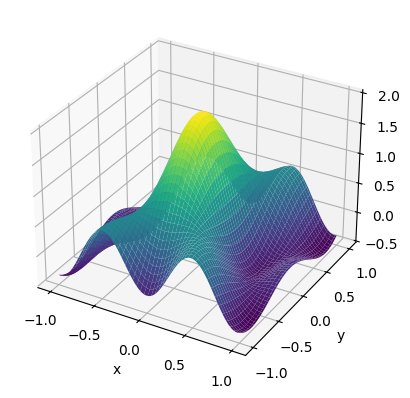

In [43]:
from qadence import (feature_map, hea, Z, QuantumModel, add, QuantumCircuit, 
                     kron, FeatureParameter, RX, RZ, VariationalParameter, RY,
                     chain, CNOT, X, Y, CRX, CRZ, I)
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit, minimize
import torch
from sympy import exp

#Constant and boundary conditions
k = 1
xmin = -1  
xmax = 1  
ymin = -1
ymax = 1
omega1 = np.pi
omega2 = 2*np.pi

def vqc_fit(n_qubits, n_epochs, x_range, y_range, xmin, xmax, k):
    
    x = FeatureParameter("x")
    y = FeatureParameter("y")
    phi = VariationalParameter("phi")
    
    block = add(
        kron(RX(0, np.sqrt(k) * x + phi), RX(1, np.sqrt(k) * y + phi)),
        kron(RY(0, omega1 * x), RY(1, omega2 * y))  # Ensure sinusoids are learned
    )
    obs = (1 / (1 + k**2)) * kron(Z(0), Z(1))
        
    circuit = QuantumCircuit(2, block)
    model = QuantumModel(circuit, observable = obs)

    optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

    for _ in range(n_epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, x_range, y_range, xmin, xmax, k)
        print("Loss:", loss)
        loss.backward()
        optimizer.step()
    # Generate predictions for the entire grid
    x_grid, y_grid = torch.meshgrid(x_range, y_range)
    u_pred = model.expectation({"x": x_grid.flatten(), "y": y_grid.flatten()}).squeeze().detach()
    u_pred = u_pred.reshape(x_grid.shape)

    return model, u_pred
    
#Once again, we need to adapt the loss function to enforce the diff. eq.

x_range = torch.linspace(-1, 1, 100)  # range of t values
y_range = torch.linspace(-1, 1, 100)  # range of t values



def loss_fn(model, x_range, y_range, xmin, xmax, k):
    
    x_range = x_range.clone().detach().requires_grad_(True)
    y_range = y_range.clone().detach().requires_grad_(True)
    
    us = model.expectation({"x": x_range, "y": y_range}).squeeze()
    print("Predictions:", us)
    
    # Compute second derivates
    dxs = torch.autograd.grad(us.sum(), x_range, create_graph=True)[0]
    dxs2 = torch.autograd.grad(dxs.sum(), x_range, create_graph=True)[0]
    
    dys = torch.autograd.grad(us.sum(), y_range, create_graph=True)[0]
    dys2 = torch.autograd.grad(dys.sum(), y_range, create_graph=True)[0]
    
    # forcing term 
    q_x_y = (k**2 - omega1**2 - omega2**2) * torch.sin(omega1 * x_range) * torch.sin(omega2 * y_range)
    
    # Check if learned derivative is behaving according to diff eq.
    residual = dxs2 + dys2 + k**2 * us - q_x_y
    
    # Enforce Dirichlet boundary conditions: u(x, ±1) = 0 and u(±1, y) = 0
    boundary_loss = (
        torch.mean(us[x_range == xmin]) +
        torch.mean(us[x_range == xmax]) +
        torch.mean(us[y_range == ymin]) +
        torch.mean(us[y_range == ymax])
    )
    
    # Total loss: MSE of residual and boundary conditions
    loss = torch.mean(residual**2) + boundary_loss*10
    
    return loss


def plot_3d(x_range, y_range, u_pred):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x, y = np.meshgrid(x_range.detach().numpy(), y_range.detach().numpy())
    u = u_pred.detach().numpy().reshape(x.shape)
    
    ax.plot_surface(x, y, u, cmap='viridis', edgecolor='none')
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    plt.show()

show = True

n_qubits = 2
model, u_p = vqc_fit(n_qubits, 100, x_range, y_range, xmin, xmax, k)
print(x_range, y_range, u_p)
if show:
    plot_3d(x_range,y_range, u_p)
vparams = model.vparams